In [187]:
# pip install requests
# pip install pandas
# pip install bs4
# pip install re

# **Gathering data for product A maggie 12 pack**

In [177]:
# Product A = 12 pack maggie

# Using requests library to get the diffrent dates HTML pages from the wayback machine
import requests
url='http://web.archive.org/cdx/search/cdx'
target='www.amazon.in/dp/B07B4KQRZG*'

try :
  response=requests.get(url,params={'url':target,
                                    'output':'json',
                                    'filter':'statuscode:200',
                                    'fl':'original,timestamp',
                                    'collapse':'timestamp:6'},timeout=30)
  response.raise_for_status()
  a_raw_data=response.json()

except requests.exceptions.RequestException as e:
  print(e)

print(type(a_raw_data))

<class 'list'>


In [178]:
# converting list of HTML pages to the dataframe
import pandas as pd

a_raw_df=pd.DataFrame(a_raw_data[1:],columns=a_raw_data[0])

# adding record date column as datatype datetime & drop dublicate values
a_raw_df['record_date']=pd.to_datetime(a_raw_df['timestamp'].to_list(),format='%Y%m%d%H%M%S').date
a_raw_df.drop_duplicates(subset=['record_date'],inplace=True)


# making url like this : https://web.archive.org/web/ + timestamp + / + original_url.
a_raw_df['webpages']='https://web.archive.org/web/'+a_raw_df['timestamp']+'/'+a_raw_df['original']


a_raw_df.head()

,original,timestamp,record_date,webpages
0,https://www.amazon.in/dp/B07B4KQRZG,20201105181717,2020-11-05,https://web.archive.org/web/20201105181717/htt...
1,http://www.amazon.in/dp/B07B4KQRZG,20210101175044,2021-01-01,https://web.archive.org/web/20210101175044/htt...
2,https://www.amazon.in/dp/B07B4KQRZG/,20211230180620,2021-12-30,https://web.archive.org/web/20211230180620/htt...
3,http://www.amazon.in/dp/B07B4KQRZG/,20220828211342,2022-08-28,https://web.archive.org/web/20220828211342/htt...
4,https://www.amazon.in/dp/B07B4KQRZG,20240807110058,2024-08-07,https://web.archive.org/web/20240807110058/htt...


In [179]:
# function will take url and return the title and price from the html page

def parse_page(webpage_link):
  import time
  import re
  from bs4 import BeautifulSoup
  result={'title':None,'price':None}
  time.sleep(10)
  try:
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response=requests.get(webpage_link,timeout=20,headers=headers)
    html=response.content
    soup=BeautifulSoup(html,'html.parser')

    if soup.find(id='productTitle') is None:
      result['title']=None
    else:
      webpage_title=soup.find(id='productTitle').get_text().strip()
      result['title']=webpage_title


    if soup.find('span',{'class':"a-price-whole"}) is not None:
      webpage_price=soup.find('span',{'class':"a-price-whole"}).get_text().strip()

    elif soup.find(id='priceblock_dealprice') is not None:
      webpage_price=soup.find(id='priceblock_dealprice').get_text().strip()

    elif soup.find(id='priceblock_ourprice') is not None:
      webpage_price=soup.find(id='priceblock_ourprice').get_text().strip()

    else:
      webpage_price=None

    if webpage_price is not None:
      webpage_final_price=re.sub(r'[^\d.]','',webpage_price)
      result['price']=float(webpage_final_price)

    else:
      result['price']=webpage_price

    return result

  except Exception as e:
    print(e)



In [180]:
# !! Need to run this cell if you want the scraped_data.I have saved the data as scraped_data (df) and loaded

## a_scraped_data=a_raw_df['webpages'].apply(parse_page)
## a_scraped_data=a_scraped_data.apply(pd.Series)
## a_scraped_data.to_csv('a_scraped_data')

# loading scraped data from the disk (You may need to change the path based on your file location)
a_scraped_data=pd.read_csv('/content/a_scraped_data')
a_scraped_data=a_scraped_data.drop("Unnamed: 0",axis=1)

In [181]:
# concatanating raw_df & scraped_data(df) & droping null values

a_raw_df=pd.concat([a_raw_df,a_scraped_data],axis=1)
a_raw_df=a_raw_df.dropna()
print(a_raw_df.head())

                                            original       timestamp  \
0                https://www.amazon.in/dp/B07B4KQRZG  20201105181717   
4                https://www.amazon.in/dp/B07B4KQRZG  20240807110058   
5               https://www.amazon.in/dp/B07B4KQRZG/  20250131224416   
6  https://www.amazon.in/dp/B07B4KQRZG/&tag=consu...  20221022171515   
7  https://www.amazon.in/dp/B07B4KQRZG/ref=as_l%E...  20230327210507   

  record_date                                           webpages  \
0  2020-11-05  https://web.archive.org/web/20201105181717/htt...   
4  2024-08-07  https://web.archive.org/web/20240807110058/htt...   
5  2025-01-31  https://web.archive.org/web/20250131224416/htt...   
6  2022-10-22  https://web.archive.org/web/20221022171515/htt...   
7  2023-03-27  https://web.archive.org/web/20230327210507/htt...   

                                             title  price  
0  Maggi 2-Minute Noodles Masala, 70g (Pack of 12)  144.0  
4  Maggi 2-Minute Noodles Masala, 70g 

In [182]:
# this function extract weight,unit and no of packs from the title

def extract_product_details(title_text):
  import re
  result={}
  if title_text is not None:

    no_of_packs=1
    grps=re.search(r'Pack of\s+(\d+)',title_text,flags=re.IGNORECASE)
    if grps:
      no_of_packs=int(grps.group(1))
      result['no_of_packs']=no_of_packs

    grps2=re.search(r'(\d*\.?\d+)\s*(g|kg|gm|gram|ml|l)',title_text,flags=re.IGNORECASE)
    if grps2:
      weight_per_pack=float(grps2.group(1))
      unit=grps2.group(2)
      result['weight_per_pack']=weight_per_pack
      result['unit']=unit
      if weight_per_pack>100 :
        total_weight=weight_per_pack
      else:
        total_weight=weight_per_pack*no_of_packs

      result['total_weight']=total_weight

    return result
  else :
    result={'weight_per_pack':None,'unit':None,'no_of_packs':None,'total_weight':None}
    return result

In [183]:
# extracting the information from the
a_information_df=a_raw_df['title'].apply(extract_product_details).apply(pd.Series)
print(a_information_df['unit'].unique())

['g' 'G']


In [184]:
# concatinating a_raw_df and a_information_df
a_all_df=pd.concat([a_raw_df,a_information_df],axis=1)

# calculating price per 100g
a_all_df['price_per_100g']=(a_all_df['price']/a_all_df['total_weight'])*100
a_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 369
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   original         99 non-null     object 
 1   timestamp        99 non-null     object 
 2   record_date      99 non-null     object 
 3   webpages         99 non-null     object 
 4   title            99 non-null     object 
 5   price            99 non-null     float64
 6   no_of_packs      87 non-null     float64
 7   weight_per_pack  99 non-null     float64
 8   unit             99 non-null     object 
 9   total_weight     99 non-null     float64
 10  price_per_100g   99 non-null     float64
dtypes: float64(5), object(6)
memory usage: 9.3+ KB


# **Gathering data for Product B Toblerone Milk Chocolate**

In [189]:
## Product B Toblerone Milk Chocolate Bar data collected from blog,news and other sources

b_data = [
    {'date': '2016-01-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-02-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-03-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-04-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-05-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-06-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-07-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-08-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-09-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-10-01', 'weight': '170g', 'price(GBP)': 1.00, 'event': 'Before shrink'},
    {'date': '2016-11-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'SHRINK EVENT (170g -> 150g)'},
    {'date': '2016-12-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-01-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-02-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-03-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-04-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-05-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-06-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-07-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
    {'date': '2017-08-01', 'weight': '150g', 'price(GBP)': 1.00, 'event': 'After shrink'},
]

In [191]:
# creating dataframe from the collected data
b_df=pd.DataFrame(b_data)

import re
# seprating unit of weight from it's value
b_df['weight']=b_df['weight'].apply(lambda x:re.sub(r'\D','',x)).astype(float)
# converting date values to datatype datetime
b_df['date']=b_df['date'].apply(pd.to_datetime)
# calculating price per 100g
b_df['price_per_100g']=(b_df['price(GBP)']/b_df['weight'])*100

b_df.tail()


,date,weight,price(GBP),event,price_per_100g
15,2017-04-01,150.0,1.0,After shrink,0.666667
16,2017-05-01,150.0,1.0,After shrink,0.666667
17,2017-06-01,150.0,1.0,After shrink,0.666667
18,2017-07-01,150.0,1.0,After shrink,0.666667
19,2017-08-01,150.0,1.0,After shrink,0.666667


# **Saving data to the database using sqlite3**

In [ ]:
import sqlite3
con=sqlite3.connect('shrinkflation.db')
cur=con.cursor()

In [ ]:
# Table 1: products
# Columns: product_id (Primary Key), product_name (e.g., "Maggi", "Toblerone"), base_currency.
# Table 2: price_history
# Columns: record_id (PK), product_id (Foreign Key), record_date, price, weight_grams, unit_price_calculated.


cur.execute("""create table  if not exists
               products(product_id integer primary key autoincrement,
               product_name text,
               base_currency text)""")

cur.execute("""create table  if not exists
               price_history(record_id integer primary key autoincrement,
               product_id integer,
               record_date text,
               price real,
               weight_grams real,
               unit_price_calculated real,
               foreign key(product_id) references products(product_id))""")

In [ ]:
res=cur.execute('select name from sqlite_master where type="table"')
res.fetchall()

[('products',), ('sqlite_sequence',), ('price_history',)]

In [ ]:
cur.execute("""insert into products (product_name,base_currency) values
                ('Maggi 2-Minute Noodles Masala (Pack of 12)','INR'),
                ('Toblerone Milk Chocolate Bar','GBP')""")

In [ ]:
con.commit()

In [ ]:
res=cur.execute('select * from products')
res.fetchall()

[(1, 'Maggi 2-Minute Noodles Masala (Pack of 12)', 'INR'),
 (2, 'Toblerone Milk Chocolate Bar', 'GBP')]

In [ ]:
cur.execute('delete from products where product_id=3')
cur.execute('delete from products where product_id=4')

In [ ]:
needed_df.rename(columns={'timestamp-datetime':'record_date',
                          'total_weight':'weight_grams',
                          'price_per_100g':'unit_price_calculated'},
                 inplace=True)
needed_df['product_id']=1
needed_df.drop(['weight_per_pack','no_of_packs','moving_average'],axis=1,inplace=True)
needed_df

,record_date,price,weight_grams,unit_price_calculated,product_id
0,2020-09-27,144.0,840.0,17.142857,1
1,2020-11-05,129.6,840.0,15.428571,1
2,2020-11-06,129.6,840.0,15.428571,1
3,2020-11-12,129.6,840.0,15.428571,1
4,2020-11-13,129.6,840.0,15.428571,1
...,...,...,...,...,...
150,2025-04-06,153.0,840.0,18.214286,1
151,2025-04-11,155.0,840.0,18.452381,1
152,2025-04-22,158.0,840.0,18.809524,1
153,2025-04-24,155.0,840.0,18.452381,1


In [ ]:
productb_df.rename(columns={'date':'record_date',
                            'weight':'weight_grams',
                            'price(GBP)':'price',
                            'price_per_100g':'unit_price_calculated'},inplace=True)
productb_df['product_id']=2
productb_df.drop(['event'],axis=1,inplace=True)

In [ ]:
productb_df

,record_date,weight_grams,price,unit_price_calculated,product_id
0,2016-01-01,170.0,1.0,0.588235,2
1,2016-02-01,170.0,1.0,0.588235,2
2,2016-03-01,170.0,1.0,0.588235,2
3,2016-04-01,170.0,1.0,0.588235,2
4,2016-05-01,170.0,1.0,0.588235,2
5,2016-06-01,170.0,1.0,0.588235,2
6,2016-07-01,170.0,1.0,0.588235,2
7,2016-08-01,170.0,1.0,0.588235,2
8,2016-09-01,170.0,1.0,0.588235,2
9,2016-10-01,170.0,1.0,0.588235,2


In [ ]:
needed_df.to_sql(name='price_history',con=con,if_exists='append',index=False)

155

In [ ]:
res=cur.execute('select * from price_history' )
res.fetchone()

(1, 1, '2020-09-27 00:00:00', 144.0, 840.0, 17.142857142857142)

In [ ]:
productb_df.to_sql(name='price_history',con=con,if_exists='append',index=False)

20

In [ ]:
res=cur.execute('select * from price_history' )
res.fetchone()

(1, 1, '2020-09-27 00:00:00', 144.0, 840.0, 17.142857142857142)

In [ ]:
# moving_avg_query=cur.execute(""" select p.product_name,h.record_date,h.unit_price_calculated,
#                                  avg(h.unit_price_calculated)
#                                  over(partition by h.product_id
#                                  order by record_date
#                                  rows between 9 preceding and current row )
#                                  from price_history h
#                                  join
#                                  products p on h.product_id=p.product_id
#                                  order by record_date
#                                  """)
# moving_avg_query.fetchall()

In [ ]:
# cur.execute("PRAGMA table_info(products)").fetchall()
# cur.execute("PRAGMA table_info(price_history)").fetchall()


In [ ]:
maggie_data_df=pd.read_sql(""" select h.record_date,h.unit_price_calculated,
                                  avg(h.unit_price_calculated)
                                  over(partition by h.product_id
                                  order by record_date
                                  rows between 9 preceding and current row )
                                  as moving_average
                                  from price_history h
                                  join
                                  products p on h.product_id=p.product_id
                                  where p.product_id=1
                                  order by record_date
                                  """,con=con)

In [ ]:
maggie_data_df['record_date']=maggie_data_df['record_date'].apply(pd.to_datetime)

In [ ]:
maggie_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   record_date            155 non-null    datetime64[ns]
 1   unit_price_calculated  155 non-null    float64       
 2   moving_average         155 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.8 KB


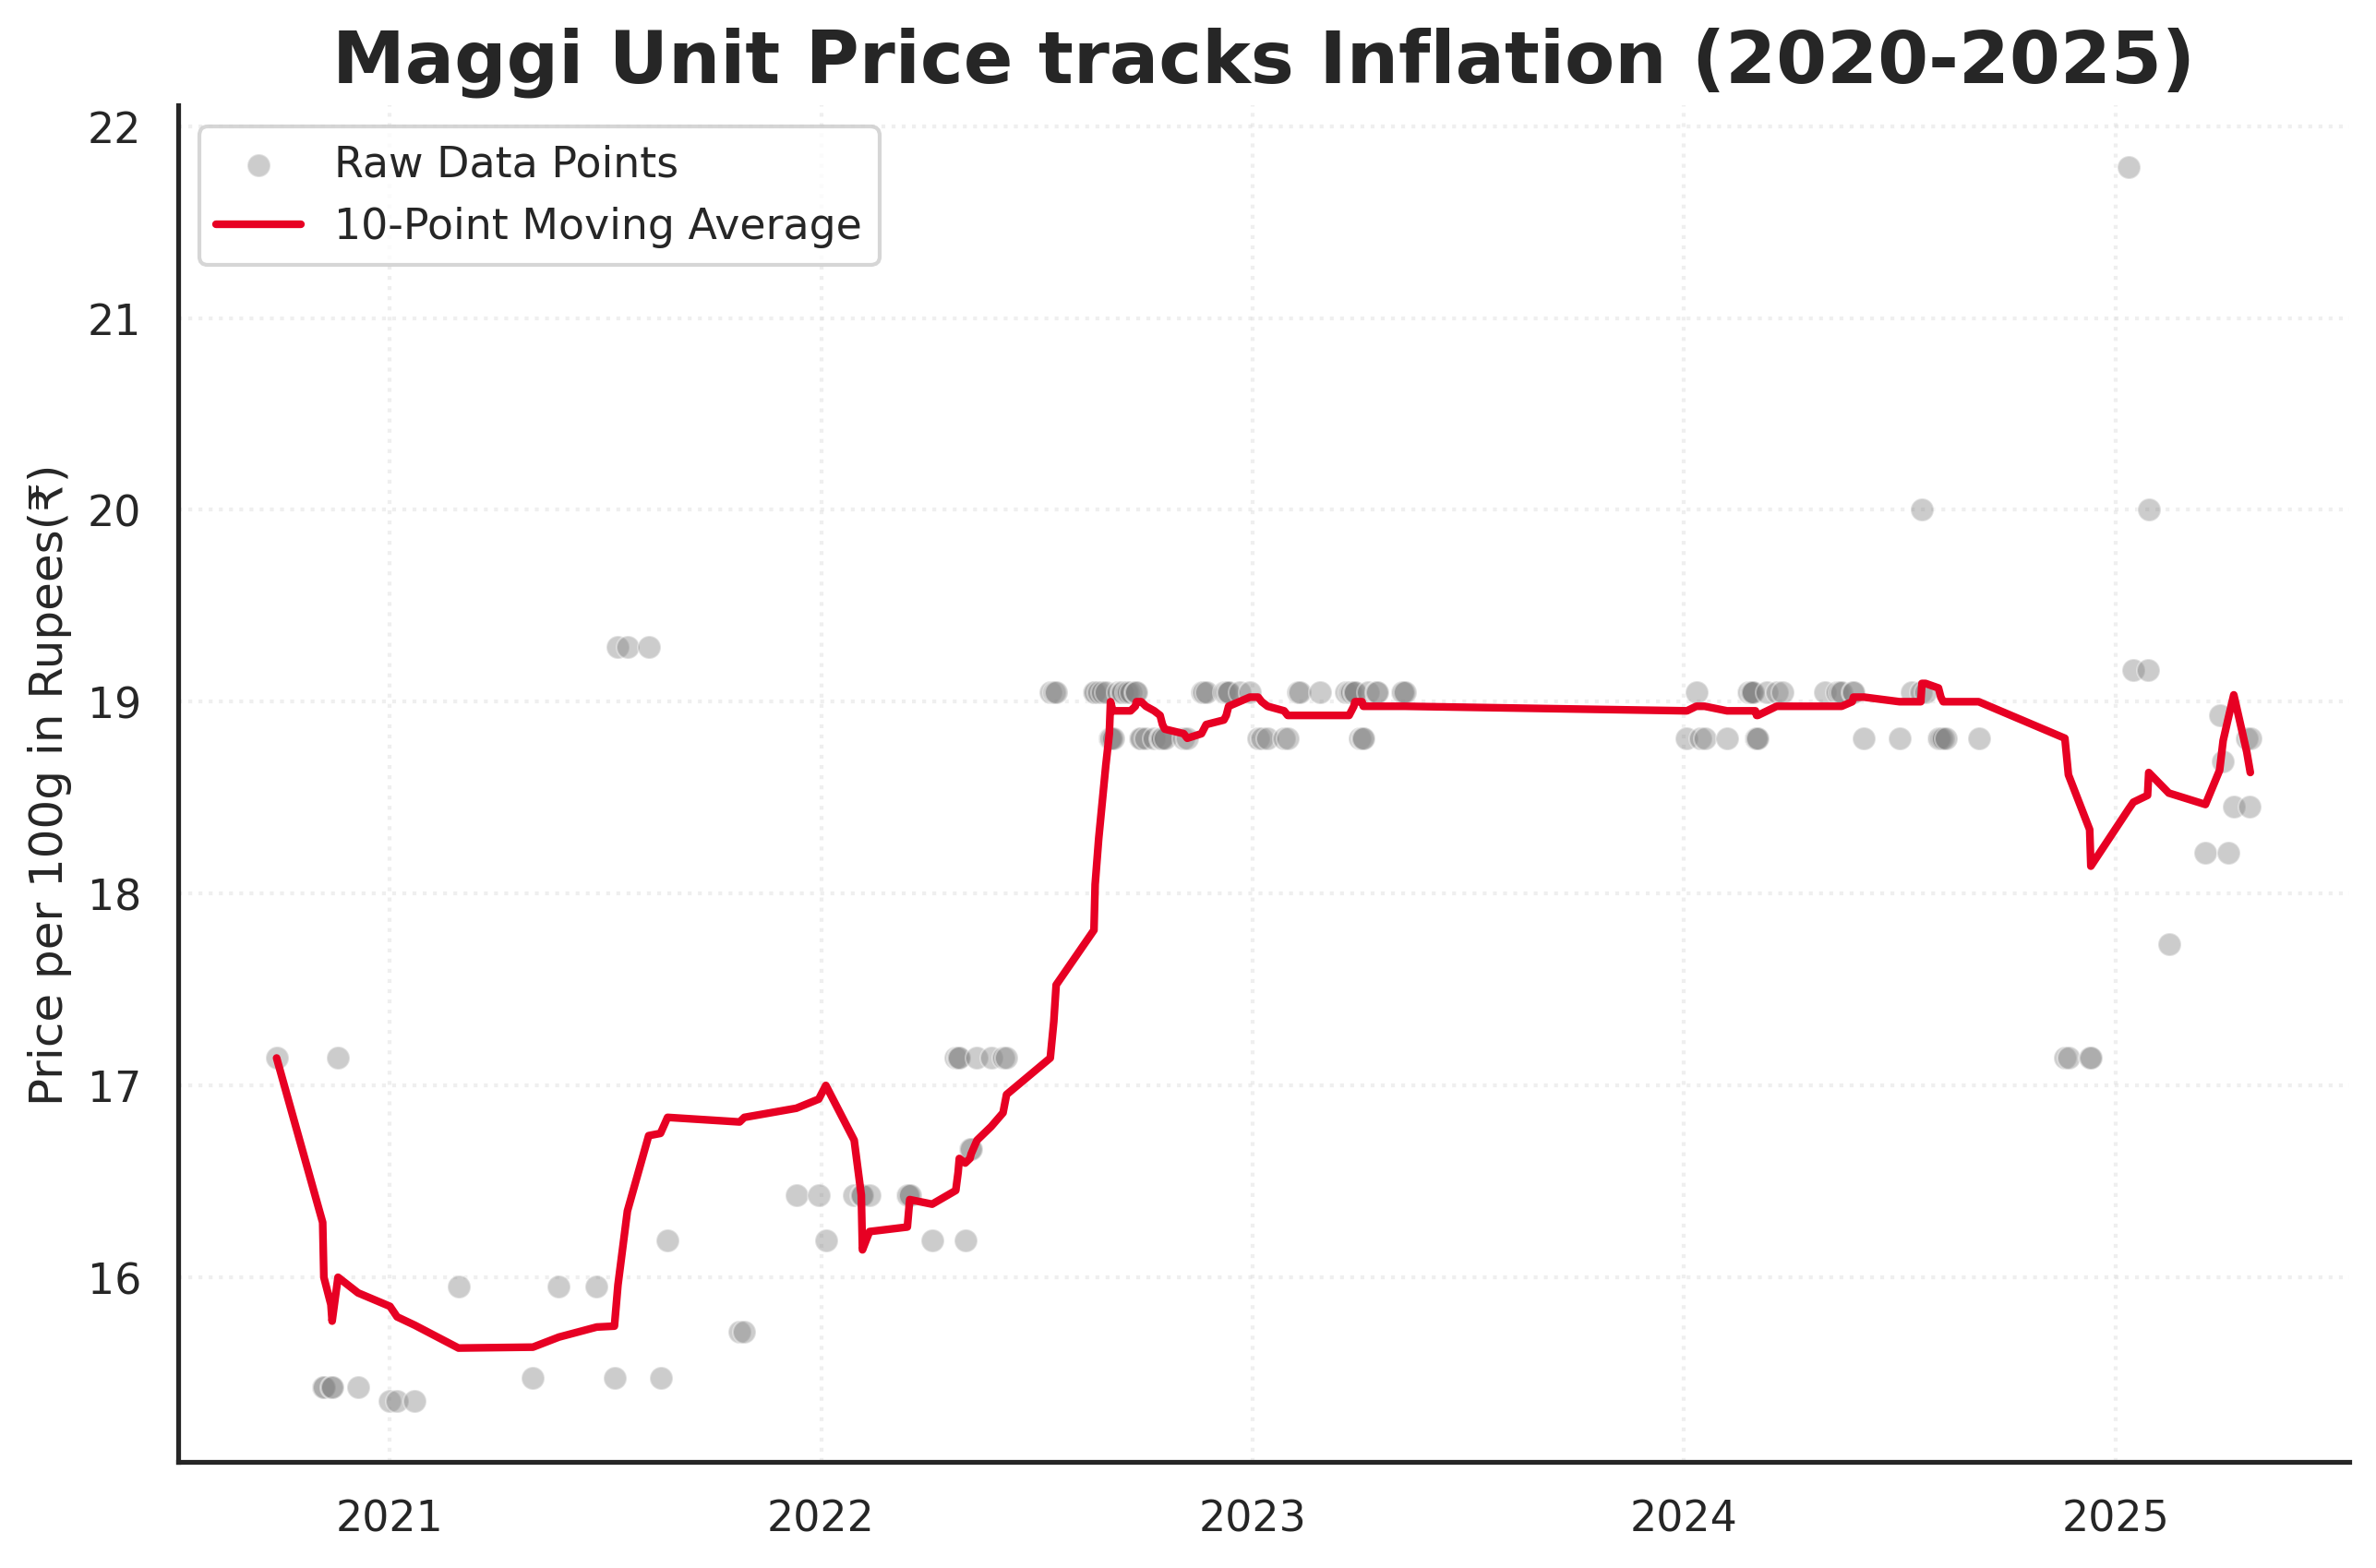

In [142]:
#E70023
#FFF01D
import seaborn as sns
plt.figure(figsize=(8,5),dpi=300)
sns.scatterplot(maggie_data_df,
                x='record_date',
                y='unit_price_calculated',
                color='grey',
                alpha=0.4,
                label='Raw Data Points')
sns.lineplot(maggie_data_df,
             x='record_date',
             y='moving_average',
             color='#E70023',
             lw=2,
             label='10-Point Moving Average'
             )

plt.xlabel('')
plt.ylabel('Price per 100g in Rupees(₹)',fontsize=12)
plt.grid(True,alpha=0.5,color='#e0e0e0',ls='dotted')
plt.title('Maggi Unit Price tracks Inflation (2020-2025)',fontsize=19,fontweight='bold')
sns.despine()
plt.savefig('Maggie unit price tracks inflation(2020-2025)',bbox_inches='tight')